# Playing with NLP 
<br>
In this notebook I will present my approach to the following task: load and analyze a dataset of job descriptions (which were previously scraped from the web) and try to assign them a particular class (10 classes). After that, I will build a classifier to predict the class of future job descriptions.

- I created a whole project folder instead of a single notebook: sometimes computation times are quite high and I chose to save pictures and dataframes (in order to not run the whole notebook each time). You can find saved dataframes in "Dataframe", imagine in "Imgs", and the dataset in "Dataset".

<br>

- Some cells present a pretty heavy computational load. Sometimes I used multiprocessing and sometimes I used my GPU. Feel free to load the various checkpoints that are present in the notebook in order to avoid wasting too much time and resources executing all the cells. 

<br>

- I will try to explain each operation in a proper way, step by step, along the notebook. 

<br>

- The general idea is the following: setting-up the kernel, exploring the dataset to get some insights, pre-processing the dataset,performing the labelling of each row (using also LDA), post-processing the data (thanks to the assigned labels) and, finally, building some classifiers to predict the class of job ads. 

<br>

<!--TABLE OF CONTENTS-->
Table of contents:
<br>
  - [Setup](#Setup)
    - [Import libraries and packages](#Import-libraries-and-packages)
    - [Import Data](#Import-Data)
  - [Exploring the dataset](#Exploring-the-dataset)
    - [General overview](#General-overview)
    - [Titles](#Titles)
    - [Descriptions](#Descriptions)
  - [Pre-Processing](#Pre-Processing)
    - [Cleaning description and title](#Cleaning-description-and-title)
    - [Removing explicit duplicates](#Removing-explicit-duplicates)
    - [Preparing doc](#Preparing-doc)
    - [Additional Duplicates](#Additional-Duplicates)
    - [Checkpoint](#Checkpoint)
  - [Labelling data and LDA](#Labelling-data-and-LDA)
    - [LDA](#LDA)
      - [Preparation](#Preparation)
      - [Building the model](#Building-the-model)
      - [Interpreting results](#Interpreting-results)
      - [Checkpoint](#Checkpoint)
    - [Rules](#Rules)
      - [Setup](#Setup)
      - [Rows with only one label found](#Rows-with-only-one-label-found)
      - [Rows with more than one label found](#Rows-with-more-than-one-label-found)
      - [Rows with no labels](#Rows-with-no-labels)
      - [Final labels](#Final-labels)
      - [Checkpoint](#Checkpoint)
  - [Post-processing](#Post-processing)
    - [Removing "hidden" duplicates](#Removing-"hidden"-duplicates)
      - [Checkpoint](#Checkpoint)
    - [Visualizations](#Visualizations)
    - [Checkpoint](#Checkpoint)
  - [Building a classifier](#Building-a-classifier)
    - [Bag of words](#Bag-of-words)
      - [Naive Bayes (multinomial)](#Naive-Bayes-(multinomial))
      - [Random forest](#Random-forest)
      - [Logistic Regression](#Logistic-Regression)
    - [TF_IDF](#TF_IDF)
      - [Naive Bayes (multinomial)](#Naive-Bayes-(multinomial))
      - [Random forest](#Random-forest)
      - [Logistic regression](#Logistic-regression)
    - [Bert](#Bert)
  - [Final remarks](#Final-remarks)

## Setup

### Import libraries and packages

In [1]:
%pip install autocorrect==2.6.1

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# The notebook is devleoper in vscode, with the jupyter notebook extension (and many other)
# The environment used for the kernel has Python 3.10.5
# The formatter Black and the linter PyCodeStyle were also used
# Requirements are listed below, feel free to uncomment and install
# %pip install autocorrect==2.6.1
# %pip install dython==0.7.1.post3
# %pip install gensim==4.2.0
# %pip install matplotlib==3.5.2
# %pip install nltk==3.7
# %pip install numpy==1.22.4
# %pip install pandarallel==1.6.1
# %pip install pandas==1.4.2
# %pip install plotly==5.8.2
# %pip install pyLDAvis==3.3.1
# %pip install recordlinkage==0.15
# %pip install scikit_learn==1.1.1
# %pip install seaborn==0.11.2
# %pip install tensorflow==2.9.1
# %pip install tqdm==4.64.0
# %pip install transformers==4.21.0
# %pip install wordcloud==1.8.2.2

In [1]:
RANDOM_SEED = 42


In [2]:
import warnings

warnings.filterwarnings("ignore")

# Data processing
import numpy as np
import pandas as pd

# Graphs
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Loadbar
from tqdm import tqdm

# For saving and reading files
import os
import pickle


### Import Data

In [3]:
df = pd.read_csv("Dataset/job_titles_and_descriptions.csv", sep=",")
df.head()


,title,description
0,Quality Assurance Inspector,Job DescriptionContract Scotland is working wi...
1,Food &amp; Beverage Assistant,About us\nWe are the nhow hotel London.\nWe ar...
2,PHP Developer,&lt;p&gt;**Fully Remote Role**&lt;/p&gt;&lt;p&...
3,Maintenance Team Leader (Manufacturing),Maintenance Team Leader (Manufacturing) Plymou...
4,Human Resources Business Partner – Talent,&lt;h3&gt;Human Resources Business Partner – T...


## Exploring the dataset

### General overview

In [58]:
# So, we have a title and a description column.
# It is already clear that a deep cleaning will be necessary: we can see capital letters, punctuations and html chars as well.
df.head()


,title,description
0,Quality Assurance Inspector,Job DescriptionContract Scotland is working wi...
1,Food &amp; Beverage Assistant,About us\nWe are the nhow hotel London.\nWe ar...
2,PHP Developer,&lt;p&gt;**Fully Remote Role**&lt;/p&gt;&lt;p&...
3,Maintenance Team Leader (Manufacturing),Maintenance Team Leader (Manufacturing) Plymou...
4,Human Resources Business Partner – Talent,&lt;h3&gt;Human Resources Business Partner – T...


In [59]:
df.tail()


,title,description
9050,Nightshift Parts Supervisor,We're recruiting for a motivated and organised...
9051,Qualified Accountant (Energy Trading),Your new company A scale up Energy Trading bus...
9052,Family Support Practitioner,"Salary: Circa £21,600 per annum, pro rata whic..."
9053,Customer Team Leader,Customer Team Leader&lt;br&gt;&lt;br&gt;All ca...
9054,Senior Java Developer,&lt;p&gt;Ever had an interest in Artificial In...


In [60]:
# Great, the dataset is pretty small: perfect for prototyping and exploring.
# The number of rows should still be enough to train a classifier.
df.columns
print("The dataset contains {0} rows".format(len(df)))
print("The dataset contains {0} columns".format(len(df.columns)))
print("Such columns are: {0}".format(df.columns))


The dataset contains 9055 rows
The dataset contains 2 columns
Such columns are: Index(['title', 'description'], dtype='object')


In [61]:
# I expected to find many more duplicates regarding the description and definetely less recurrent titles.add()
# This simple dataframe description alreadu suggests that our dataset might contain row duplicates.
df.describe()


,title,description
count,9055,9055
unique,4618,8377
top,Registered Nurse,My Four Wheels are looking to expand our team ...
freq,311,85


In [62]:
# Very well: two strign columns with no null values!
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        9055 non-null   object
 1   description  9055 non-null   object
dtypes: object(2)
memory usage: 141.6+ KB


In [63]:
# It seems that all the descriptions have at least some sense
print(
    "Number of descriptions with at least 3 chars: {0}".format(
        (df["description"].apply(lambda x: len(x) > 3).sum())
    )
)


Number of descriptions with at least 3 chars: 9055


In [64]:
# It seems that all the titles have at least some sense
print(
    "Number of titles with at least 3 chars: {0}".format(
        (df["title"].apply(lambda x: len(x) > 3).sum())
    )
)


Number of titles with at least 3 chars: 9055


### Titles

In [41]:
# Create function to build the word cloud
from wordcloud import WordCloud


def build_wordcloud(words):
    """Function to build a wordcloud, given an iterable of strings

    Args:
        words: input set/list/series (...) of words

    Returns:
        Image wordcloud
    """
    long_string = ",".join(words)
    wordcloud = WordCloud(
        background_color="white",
        max_words=5000,
        contour_width=3,
        contour_color="steelblue",
    )
    wordcloud.generate(long_string)
    return wordcloud.to_image()


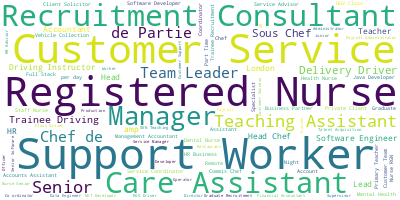

In [66]:
# We can find many keywords from the 10 expected classe in the job titles!
build_wordcloud(df["title"])


In [67]:
print("Total number of titles: {0}".format(df["title"].count()))
print("Total unique number of titles: {0}".format(df["title"].nunique()))
print(
    "Average frequency of titles: {0}".format(
        round(df["title"].count() / df["title"].nunique()), 2
    )
)


Total number of titles: 9055
Total unique number of titles: 4618
Average frequency of titles: 2


In [4]:
# As expected, the majority of titles have very low occurrences. I did not expect to find some titles with hundreds of occurrences.
df_plot = df.groupby("title")["description"].count().reset_index()
df_plot.rename(columns={"description": "n_occurrences"}, inplace=True)
fig = px.histogram(
    df_plot,
    x="n_occurrences",
    width=1000,
    height=500,
    title="Frequency of n_occurrences",
)
fig.show()


In [69]:
# Let's check if this is a Pareto distribution.
from math import ceil

total = df_plot["n_occurrences"].sum()
df_plot.sort_values("n_occurrences", ascending=False, inplace=True)
partial = df_plot[0 : ceil(0.2 * len(df_plot))]["n_occurrences"].sum()
print(
    "20% of titles are responsible for {0} occurrences".format(
        round(partial / total, 2)
    )
)
# Nope, no Pareto here (it should have been something like 20% of titles responsible for 80% of occurrences)
# This is not a bad thing actually, since the occurrences (and therefore the rows) will be better distributed between rows


20% of titles are responsible for 0.58 occurrences


In [5]:
# As above, but for unique descriptions
df_plot = df.groupby("title")["description"].nunique().reset_index()
df_plot.rename(columns={"description": "n_unique_desc"}, inplace=True)
fig = px.histogram(
    df_plot,
    x="n_unique_desc",
    width=1000,
    height=500,
    title="Frequency of n_unique_desc",
)
fig.show()


In [6]:
# The distribution of the number of characters does not show particular patterns. It looks a bit like a normal distribution.
df["str_len"] = df["title"].apply(lambda x: len(x))
df_plot = df.groupby("title")["str_len"].mean().reset_index()
fig = px.histogram(
    df_plot, x="str_len", width=1000, height=500, title="Frequency of str_len"
)
fig.show()


In [72]:
# df["title"].apply(lambda x: len(x.split(" "))).sum()
df["title"].apply(lambda x: len(set(x.split(" ")))).sum()


35538

In [7]:
# Pretty interesting: that count for words and unique words follow similar distributions.
# We only observe a higher count of n_words for max values.
df["n_words"] = df["title"].apply(lambda x: len(x.split(" ")))
df["unique_words"] = df["title"].apply(lambda x: len(set(x.split(" "))))
df_plot = df.groupby("title")["n_words", "unique_words"].mean().reset_index()
fig = px.histogram(
    df_plot,
    x=["n_words", "unique_words"],
    width=1000,
    height= 500,
    title="Frequency of n_words",
    barmode="group",
)
fig.show()


In [74]:
# It seems that inside titles words are rarely repeated.
print("Total number of words: {0}".format(df["n_words"].sum()))
print("Total unique number of words: {0}".format(df["unique_words"].sum()))
print(
    "Average frequency of words: {0}".format(
        round(df["n_words"].sum() / df["unique_words"].sum()), 2
    )
)


Total number of words: 36125
Total unique number of words: 35538
Average frequency of words: 1


In [75]:
# Eploring this dataframe a bit, we can notice that words are repeated mainly for some topics: chef, driver, developer
df[df["n_words"] > df["unique_words"]].head()


,title,description,str_len,n_words,unique_words
40,Chef de Partie / Junior Sous Chef,Chef de Partie/ Junior Sous Chef Kent 2AA Rose...,33,7,6
86,Teaching Assistant - Primary?SEND? - Full Time,Teaching Assistant - Primary SEND - Full Time ...,46,7,6
94,Chefs - Hotels - Tower Bridge,Agency Chef de Partie - Hotels in the City Ber...,29,6,5
156,Support Worker/Senior Support Worker,*Why work for Corserv Care? Let me tell you wh...,36,4,3
195,Nursery Teacher (EYFS)/ Reception Teacher (EYFS),Nursery Teacher (EYFS) / Reception Teacher (EY...,48,6,5


### Descriptions

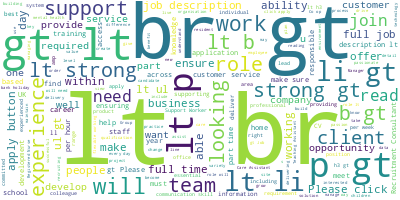

In [76]:
# This is a complete mess of html tags. It is vital to clean them well later.
build_wordcloud(df["description"])


In [77]:
print("Total number of descriptions: {0}".format(df["description"].count()))
print("Total unique number of descriptions: {0}".format(df["description"].nunique()))
print(
    "Average frequency of descriptions: {0}".format(
        round(df["description"].count() / df["description"].nunique()), 2
    )
)


Total number of descriptions: 9055
Total unique number of descriptions: 8377
Average frequency of descriptions: 1


In [8]:
# Similar observations that I made for the titles.
df_plot = df.groupby("description")["title"].count().reset_index()
df_plot.rename(columns={"title": "n_occurrences"}, inplace=True)
fig = px.histogram(
    df_plot,
    x="n_occurrences",
    width=1000,
    height=500,
    title="Frequency of n_occurrences",
)
fig.show()


In [79]:
# Let's try Pareto
from math import ceil

total = df_plot["n_occurrences"].sum()
df_plot.sort_values("n_occurrences", ascending=False, inplace=True)
partial = df_plot[0 : ceil(0.2 * len(df_plot))]["n_occurrences"].sum()
print(
    "20% of descriptions are responsible for {0} occurrences".format(
        round(partial / total, 2)
    )
)
# No Pareto here: the relation is even weaker in this case.


20% of descriptions are responsible for 0.26 occurrences


In [9]:
df_plot = df.groupby("description")["title"].nunique().reset_index()
df_plot.rename(columns={"title": "n_unique_desc"}, inplace=True)
fig = px.histogram(
    df_plot,
    x="n_unique_desc",
    width=1000,
    height=500,
    title="Frequency of n_unique_desc",
)
fig.show()


In [10]:
# We can notice a peculiarity: while the distribution mainly looks like a normal one, there is a very high peak for some low values.
df["str_len"] = df["description"].apply(lambda x: len(x))
df_plot = df.groupby("description")["str_len"].mean().reset_index()
fig = px.histogram(
    df_plot, x="str_len", width=1000, height=500, title="Frequency of str_len"
)
fig.show()


In [11]:
# The number of words recalls the previous distribution, while the unique words number is very similar, but a bit shifted to the left
df["n_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["unique_words"] = df["description"].apply(lambda x: len(set(x.split(" "))))
df_plot = df.groupby("description")["n_words", "unique_words"].mean().reset_index()
fig = px.histogram(
    df_plot,
    x=["n_words", "unique_words"],
    width=1000,
    height=500,
    title="Frequency of n_words",
    barmode="group",
)
fig.show()


In [83]:
# I expected a higher number of repeated words per description.
print("Total number of words: {0}".format(df["n_words"].sum()))
print("Total unique number of words: {0}".format(df["unique_words"].sum()))
print(
    "Average frequency of words: {0}".format(
        round(df["n_words"].sum() / df["unique_words"].sum()), 2
    )
)


Total number of words: 2500418
Total unique number of words: 1567537
Average frequency of words: 2


In [84]:
df.drop(["str_len", "n_words", "unique_words"], axis=1, inplace=True)
df.head()


,title,description
0,Quality Assurance Inspector,Job DescriptionContract Scotland is working wi...
1,Food &amp; Beverage Assistant,About us\nWe are the nhow hotel London.\nWe ar...
2,PHP Developer,&lt;p&gt;**Fully Remote Role**&lt;/p&gt;&lt;p&...
3,Maintenance Team Leader (Manufacturing),Maintenance Team Leader (Manufacturing) Plymou...
4,Human Resources Business Partner – Talent,&lt;h3&gt;Human Resources Business Partner – T...


## Pre-Processing

### Cleaning description and title

In [85]:
# Lower all characters for both title and description
df["description"] = df["description"].apply(lambda x: x.lower())
df["title"] = df["title"].apply(lambda x: x.lower())


In [86]:
# For the descriptions only, I noticed that many times the word "description" has no whitespace after
has_desc = df["description"].apply(lambda x: "description" in x).sum()
has_desc_whitespace = df["description"].apply(lambda x: "description " in x).sum()
print(
    "{0} description contain the word description, but only {1} have a space after that".format(
        has_desc, has_desc_whitespace
    )
)


3612 description contain the word description, but only 1024 have a space after that


In [87]:
# For the descriptions only, I noticed that many times there were html tags
has_html_tag = df["description"].apply(lambda x: "&lt;" in x).sum()
has_html_tag


3062

In [88]:
# For the descriptions only, I noticed that sometimes there were newline or tablature escapes
has_new_line = df["description"].apply(lambda x: "\n" in x).sum()
has_tab = df["description"].apply(lambda x: "\t" in x).sum()
has_new_line


547

In [89]:
# Let's clean the description
def clean_desc(desc: str):
    """Function used to build the description from the just discussed issues

    Args:
        desc: description to clean

    Returns:
        ok description
    """
    desc = desc.replace("description", "description ")
    desc = desc.replace("&lt;", " < ")  # make the tag explicit
    desc = desc.replace("&gt;", " > ")  # make the tag explicit
    desc = desc.replace(r"/", " ")  # might close a tag
    desc = desc.replace("\n", " ")
    desc = desc.replace("\t", " ")
    return desc


df["description"] = df["description"].apply(clean_desc)


In [90]:
# we now have separated the tag content from special characters, they will be like " < ... > "
has_html_tag_content = (
    df["description"]
    .apply(lambda x: " li " in x or " p " in x or " br " in x or " gt " in x)
    .sum()
)
has_html_tag_content


3132

In [91]:
# let's remove them
df["description"] = df["description"].str.replace(r"<[^<>]*>", " ", regex=True)


In [92]:
import re


def remove_special_chars(s: str):
    s = re.sub("&#?[a-z0-9]+;", " ", s)  # remove other html special characters
    s = re.sub(
        "[^A-Za-z0-9]+", " ", s
    )  # remove all special characters and punctuations
    return s


df["title"] = df["title"].apply(remove_special_chars)
df["description"] = df["description"].apply(remove_special_chars)


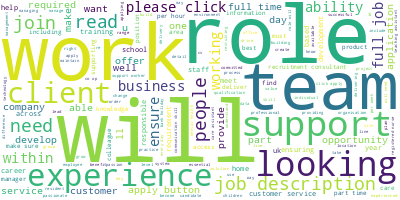

In [93]:
# Let's give a look at the freshly prepared description
build_wordcloud(df["description"])
# Much better!


### Removing explicit duplicates

In [94]:
# explicit duplicates = rows with same title and description
# before removing them, let's investigate a little
df["dupli"] = 0
df_agg = df.groupby(["title", "description"])
id_dupli = 0
for name, group in df_agg:
    if len(group) > 1:
        id_dupli += 1
        df.loc[group.index, "dupli"] = id_dupli
df
# After this, only duplicate rows will share the same value for column "dupli"
# All rows with no duplicates will have value 0


,title,description,dupli
0,quality assurance inspector,job description contract scotland is working w...,0
1,food beverage assistant,about us we are the nhow hotel london we are a...,0
2,php developer,fully remote role uk based applicants only my...,0
3,maintenance team leader manufacturing,maintenance team leader manufacturing plymouth...,0
4,human resources business partner talent,human resources business partner talent oakle...,0
...,...,...,...
9050,nightshift parts supervisor,we re recruiting for a motivated and organised...,274
9051,qualified accountant energy trading,your new company a scale up energy trading bus...,0
9052,family support practitioner,salary circa 21 600 per annum pro rata which e...,0
9053,customer team leader,customer team leader all candidates should mak...,0


In [95]:
# Let's add the group size
df_dupli = (
    df.loc[df["dupli"] > 0]
    .groupby("dupli")["title"]
    .count()
    .reset_index()
    .rename(columns={"title": "group_size"})
)
# Let's get the max group and its dupli id
max_size = df_dupli["group_size"].max()
id_max_size = df_dupli[df_dupli["group_size"] == df_dupli["group_size"].max()][
    "dupli"
].values[0]
# And now check such group
df[df["dupli"] == id_max_size].head()


,title,description,dupli
113,vehicle collection and delivery driver,become a bca logistics contractor driver from ...,427
355,vehicle collection and delivery driver,become a bca logistics contractor driver from ...,427
740,vehicle collection and delivery driver,become a bca logistics contractor driver from ...,427
1423,vehicle collection and delivery driver,become a bca logistics contractor driver from ...,427
1733,vehicle collection and delivery driver,become a bca logistics contractor driver from ...,427


In [96]:
# some stats
n_duplicates = len(df[df["dupli"] > 0])
n_duplicate_gropus = df["dupli"].max()
print("Total number of duplicate: {0}".format(n_duplicates))
print("Number of duplicate groups: {0}".format(n_duplicate_gropus))
print(
    "Average size of duplicate groups: {0}".format(
        round(n_duplicates / n_duplicate_gropus), 2
    )
)
print("The group with maximum size has {0} duplicates".format(max_size))


Total number of duplicate: 1077
Number of duplicate groups: 432
Average size of duplicate groups: 2
The group with maximum size has 34 duplicates


In [97]:
# remove explicit duplicates
prev_rows = len(df)
df.drop_duplicates(subset=["title", "description"], inplace=True, keep="first")
after_rows = len(df)
print(
    "While removing duplicates, {0} records where deleted".format(
        prev_rows - after_rows
    )
)


While removing duplicates, 645 records where deleted


In [98]:
df.drop(["dupli"], axis=1, inplace=True)
df.head()


,title,description
0,quality assurance inspector,job description contract scotland is working w...
1,food beverage assistant,about us we are the nhow hotel london we are a...
2,php developer,fully remote role uk based applicants only my...
3,maintenance team leader manufacturing,maintenance team leader manufacturing plymouth...
4,human resources business partner talent,human resources business partner talent oakle...


### Preparing doc

In [99]:
# I will create a single column with all the information inside.
# It will later feed all the ML models
df["doc"] = df["title"] + " " + df["description"]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


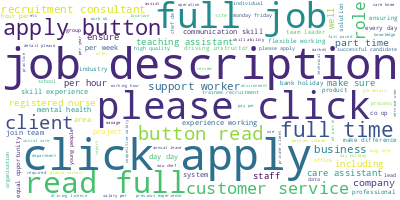

In [100]:
# I will use pandarallel for easy, plug and play pandas multiprocessing
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from autocorrect import Speller

stop_words = stopwords.words("english")  # english stopwords
lemmatizer = WordNetLemmatizer()  # english lemmatizer
spell = Speller(lang="en")  # english speller


def normalize_document(doc):

    # whitespaces
    doc = doc.strip()

    # tokenize document
    tokens = [word for word in doc.split(" ") if len(word) > 1]

    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # correct spelling mistakes
    correct_text = [spell(token) for token in filtered_tokens]

    # lemmatise document from filtered tokens
    lem_text = [lemmatizer.lemmatize(i) for i in correct_text]

    # remove words that are only one character (again, after the operations)
    lem_text = [token for token in lem_text if len(token) > 1]

    # remove numbers, but not words that contain numbers
    lem_text = [token for token in lem_text if not token.isnumeric()]

    doc = " ".join(lem_text)
    return doc


df["doc"] = df["doc"].parallel_apply(normalize_document)
# let's check the word cloud after all these operations
build_wordcloud(df["doc"])


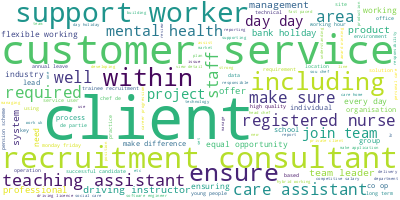

In [101]:
# there are some words which are quite common and that do not define any particular job class.
# they could potentially skew the models later, so it is better to remove them now
general_words = [
    "apply",
    "button",
    "read",
    "full",
    "time",
    "click",
    "please",
    "job",
    "description",
    "role",
    "company",
    "per",
    "week",
    "skill",
    "experience",
    "business",
    "managemenet",
    "knowledge",
    "partner",
    "skills",
    "manager",
]


def remove_gen_words(doc):
    # tokenize document
    tokens = doc.split(" ")
    doc = [token for token in tokens if token not in general_words]
    doc = " ".join(doc)
    return doc


df["doc"] = df["doc"].apply(remove_gen_words)
# let's check the word cloud after this too
build_wordcloud(df["doc"])


### Additional Duplicates

In [102]:
# Some additional explicit duplicates may be found now
prev_rows = len(df)
df.drop_duplicates(subset=["doc"], inplace=True, keep="first")
after_rows = len(df)
print(
    "While removing duplicates, {0} records where deleted".format(
        prev_rows - after_rows
    )
)


While removing duplicates, 47 records where deleted


### Checkpoint

In [103]:
# import os
# os.makedirs("Dataframes", exist_ok=True)
# df.to_csv("Dataframes/df_with_doc.csv", index=False)


In [41]:
# df = pd.read_csv("Dataframes/df_with_doc.csv")


## Labelling data and LDA

### LDA
Why LDA?
<br>
I chose to develop a simple LDA model in order to obtain two things:

- continuing the data exploration, finding similarities and differences between the clusters,
- developing a tool which can later help us with the labelling phase.

<br>
We could also use the LDA model to predict future records, however it would not be the best idea. It is a model which aims at clustering and explaining a complete dataset and while it could also perform basic predictions, it is not its main goal.

#### Preparation

In [42]:
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary

# Let's perform the necessary operations before developing the LDA model

corpus = df["doc"]
# Tokenise the corpus
tokenized_corp = [word_tokenize(i) for i in corpus]
# Create Dictionary
id2word = Dictionary(tokenized_corp)

# Remove words that don't feature 2 times and those that feature in over 60% of documents
id2word.filter_extremes(no_below=2, no_above=0.6)

texts = tokenized_corp

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [6]:
from gensim.models import CoherenceModel, LdaMulticore

# Let's perform a grid search on the number of topics to check the coherence scores
# We know a priori that we will use 10 topics, but using LDA we can check if such number is the best
# For instance, we might find that using less topics we get better clusters
#   - in this case we will have to define rules to then map the clusters to our 10 labels
# On the other hand, we might find that many more clusters are needed
#   - we will have then to merge some clusters in order to obtain the 10 labels


start = 1
step = 1
end = 20


def compute_coherence_values(corpus, dictionary, texts, end, start, step):

    coherence_values = []
    model_list = []

    for num_topics in tqdm(range(start, end, step)):

        # Build LDA model (multicore)
        lda_model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=RANDOM_SEED,
            chunksize=100,
            passes=100,
            per_word_topics=True,
        )
        model_list.append(lda_model)

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(
    corpus=corpus, dictionary=id2word, texts=texts, start=start, end=end, step=step
)


100%|██████████| 19/19 [26:44<00:00, 84.46s/it] 


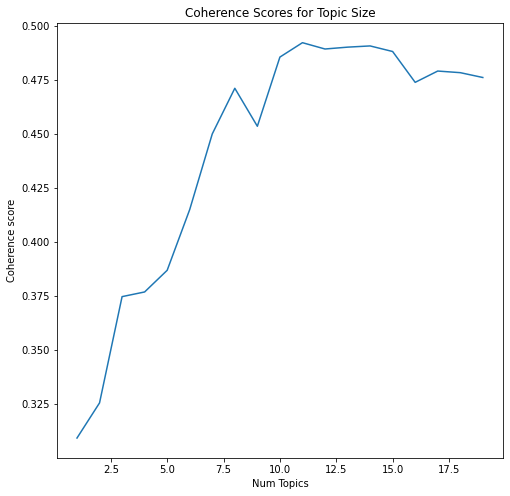

In [7]:
# Show graph
x = range(start, end, step)
ax = plt.subplots(figsize=(8, 8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores for Topic Size")
plt.show()
# We can see that n_topics=10 is definetely not bad!
# This image is saved in the "Imgs" folder!


#### Building the model

In [43]:
# Let's build our LDA model with 10 topics and a bit more passes in order to increase the coherence of the clusters
from gensim.models import CoherenceModel, LdaMulticore

lda_model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=RANDOM_SEED,
    chunksize=100,
    passes=500,
    per_word_topics=True,
)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=texts, dictionary=id2word, coherence="c_v"
)
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)


Coherence Score:  0.48339855218005584


In [44]:
# save model
# lda_model.save("Models/lda/lda_model")


In [45]:
# load model
# lda_model.load("Models/lda/lda_model")


#### Interpreting results

In [46]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())


[(0, '0.049*"chef" + 0.021*"food" + 0.015*"restaurant" + 0.014*"kitchen" + 0.014*"de" + 0.013*"head" + 0.012*"looking" + 0.012*"partie" + 0.011*"sou" + 0.011*"view"'), (1, '0.032*"nurse" + 0.012*"patient" + 0.012*"work" + 0.011*"hour" + 0.010*"registered" + 0.010*"clinical" + 0.009*"care" + 0.008*"opportunity" + 0.008*"hospital" + 0.007*"shift"'), (2, '0.063*"customer" + 0.026*"service" + 0.017*"store" + 0.016*"co" + 0.014*"help" + 0.012*"need" + 0.012*"working" + 0.010*"great" + 0.010*"leader" + 0.010*"people"'), (3, '0.033*"care" + 0.024*"support" + 0.014*"people" + 0.012*"day" + 0.011*"work" + 0.010*"make" + 0.010*"life" + 0.009*"hour" + 0.009*"home" + 0.009*"worker"'), (4, '0.037*"recruitment" + 0.018*"client" + 0.015*"consultant" + 0.013*"candidate" + 0.010*"work" + 0.009*"opportunity" + 0.009*"looking" + 0.008*"working" + 0.007*"career" + 0.007*"talent"'), (5, '0.012*"developer" + 0.012*"data" + 0.010*"software" + 0.008*"engineer" + 0.008*"work" + 0.008*"working" + 0.008*"technol

In [47]:
import pyLDAvis
import pyLDAvis.gensim_models

# Visualize the topics using this really helpful library
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared


/home/andrea/miniconda3/envs/StandardDSEnv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/andrea/miniconda3/envs/StandardDSEnv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/andrea/miniconda3/envs/StandardDSEnv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/andrea/miniconda3/envs/StandardDSEnv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprec

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.002377  0.064285       1        1  20.139446
9      0.072910  0.008393       2        1  18.819777
5      0.103270  0.028463       3        1  12.854933
4      0.088697 -0.017367       4        1  12.769815
7      0.047922 -0.050915       5        1   8.562937
8      0.102853 -0.068621       6        1   7.390375
1      0.016183 -0.029470       7        1   5.994586
2     -0.148807  0.295512       8        1   5.521559
6     -0.330195 -0.167220       9        1   4.072595
0      0.049545 -0.063060      10        1   3.873977, topic_info=             Term         Freq        Total Category  logprob  loglift
6        customer  7197.000000  7197.000000  Default  30.0000  30.0000
232          care  9305.000000  9305.000000  Default  29.0000  29.0000
181   recruitment  7103.000000  7103.000000  Default  28.0000  28.0000
1151        nurse  3628.000000  3628.000000  Default  27.0000  27.0000
526          chef  2442.000000  2442.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
121           day   216.993419  7370.293724  Topic10  -5.4297  -0.2745
366       service   210.432067  9884.236158  Topic10  -5.4604  -0.5986
440          part   188.565242  4295.990592  Topic10  -5.5701   0.1249
439           new   186.261515  4328.439226  Topic10  -5.5824   0.1051
685      standard   181.620621  1579.248987  Topic10  -5.6076   1.0881

[787 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2207      2  0.053131    35k
2207      4  0.920946    35k
2552      2  0.013688    6am
2552      7  0.123194    6am
2552      8  0.855513    6am
...     ...       ...    ...
784       1  0.275442  young
784       4  0.031738  young
784       5  0.685772  young
784      10  0.006801  young
8045      5  0.984258    zen

[2161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 6, 5, 8, 9, 2, 3, 7, 1])

The graph above allows us to check the overlapping and the distances between the 10 clusters.
Since it is obtained with dimensionality reduction, we should not gety  too scared with cluesters that are positioned really close.
We can also check (using the slider at the top right of the image) what are the unique words that mainly define a cluster, as well as the shared words that cause similarities between clusters. For instance, words like "accounting", "nurse", "food" and so on appear to be pretty unique.
On the other hand, words like "care", "service", "work" are incredibly common among our clusters.
Playing with the dictionary filter, with number of passes and with the chunksize, it is surely possible to greatly improve the result.

In [12]:
# Let's assign the 3 top topics and their probability to the dataset

topics_df1 = pd.DataFrame()
topics_df2 = pd.DataFrame()
topics_df3 = pd.DataFrame()
from tqdm import tqdm

for i, row_list in tqdm(enumerate(lda_model[corpus]), total=len(lda_model[corpus])):
    row = row_list[0] if lda_model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if len(row) >= 3:
            if j == 0:
                topics_df1 = topics_df1.append(
                    pd.Series([int(topic_num), prop_topic]), ignore_index=True
                )
            elif j == 1:
                topics_df2 = topics_df2.append(
                    pd.Series([int(topic_num), prop_topic]), ignore_index=True
                )
            elif j == 2:
                topics_df3 = topics_df3.append(
                    pd.Series([int(topic_num), prop_topic]), ignore_index=True
                )
            else:
                break
        elif len(row) == 2:
            if j == 0:
                topics_df1 = topics_df1.append(
                    pd.Series([int(topic_num), prop_topic]), ignore_index=True
                )
            elif j == 1:
                topics_df2 = topics_df2.append(
                    pd.Series([int(topic_num), prop_topic]), ignore_index=True
                )
                topics_df3 = topics_df3.append(
                    pd.Series([np.nan, "0"]), ignore_index=True
                )
        elif len(row) == 1:
            topics_df1 = topics_df1.append(
                pd.Series([int(topic_num), prop_topic]), ignore_index=True
            )
            topics_df2 = topics_df2.append(pd.Series([np.nan, "0"]), ignore_index=True)
            topics_df3 = topics_df3.append(pd.Series([np.nan, "0"]), ignore_index=True)
        elif len(row) == 0:
            topics_df1 = topics_df1.append(pd.Series([np.nan, "0"]), ignore_index=True)
            topics_df2 = topics_df2.append(pd.Series([np.nan, "0"]), ignore_index=True)
            topics_df3 = topics_df3.append(pd.Series([np.nan, "0"]), ignore_index=True)


topics_df1.rename(columns={0: "1st Topic", 1: "1st Topic Contribution"}, inplace=True)
topics_df2.rename(columns={0: "2nd Topic", 1: "2nd Topic Contribution"}, inplace=True)
topics_df3.rename(columns={0: "3rd Topic", 1: "3rd Topic Contribution"}, inplace=True)

topics_comb = pd.concat([topics_df1, topics_df2, topics_df3], axis=1, sort=False)

# #Join topics dataframe to original data
df = df.reset_index()
df = pd.concat([df, topics_comb], axis=1, sort=False)


100%|██████████| 8363/8363 [00:24<00:00, 337.00it/s]


In [13]:
df.drop(columns=["index"], axis=1, inplace=True)
df.head()


,title,description,doc,1st Topic,1st Topic Contribution,2nd Topic,2nd Topic Contribution,3rd Topic,3rd Topic Contribution
0,quality assurance inspector,job description contract scotland is working w...,quality assurance inspector contract scotland ...,9.0,0.632765,0.0,0.181228,8.0,0.166516
1,food beverage assistant,about us we are the nhow hotel london we are a...,food beverage assistant now hotel london quirk...,0.0,0.557541,3.0,0.421936,NaN,0
2,php developer,fully remote role uk based applicants only my...,php developer fully remote uk based applicant ...,5.0,0.603861,4.0,0.224173,8.0,0.157672
3,maintenance team leader manufacturing,maintenance team leader manufacturing plymouth...,maintenance team leader manufacturing maintena...,9.0,0.588439,4.0,0.195373,8.0,0.155521
4,human resources business partner talent,human resources business partner talent oakle...,human resource talent human resource talent oa...,5.0,0.779751,9.0,0.207631,NaN,0


In [14]:
# Show some samplef from each cluster
for i in range(10):
    print(
        df.loc[
            (df["1st Topic Contribution"] > 0.9) & (df["1st Topic"] == i),
            ["title", "1st Topic"],
        ].sample(10, random_state=43)
    )


                                            title  1st Topic
2942                               chef de partie        0.0
1634                  chef de partie luxury hotel        0.0
330                         restaurant supervisor        0.0
7476                      cook molesey permanent         0.0
269   breakfast manager luxury hotel in berkshire        0.0
3665                                    sous chef        0.0
5826                                    sous chef        0.0
4240                     restaurant floor manager        0.0
2500                                 chefs hotels        0.0
7094                               chef de partie        0.0
                                 title  1st Topic
5419                       staff nurse        1.0
6343         critical care staff nurse        1.0
3305                      mac operator        1.0
7383                       staff nurse        1.0
989                        staff nurse        1.0
810   staff nurse south bank 

Using the graph above as well as some samples from the various clusters, we are to map our 10 job categories to the 10 topics that LDA found in the dataset.
 - 0: food
 - 1: healthcare
 - 2: customer service
 - 3: social care
 - 4: hr
 - 5: tech
 - 6: transportation
 - 7: teaching
 - 8: accounting
 - 9: manufacturing

#### Checkpoint

In [19]:
# os.makedirs("Dataframes", exist_ok=True)
# df.to_csv("Dataframes/df_with_LDA.csv", index=False)


In [ ]:
# df = pd.read_csv("Dataframes/df_with_LDA.csv")


### Rules

#### Setup

In [21]:
# I will use insights from the exploration phase, from topic knowledge and from the LDA results to define some keywords
# Such keywords will be used to label the rows


# Important: order the keywords tuples according to the order of the topics of LDA for consistency between the two approaches
keywords = [
    # 0: food
    ("chef", "food", "kitchen", "restaurant"),
    # 1: healthcare
    ("nurse", "clinical"),
    # 2: customer service
    (
        "customer service",
        "client service",
        "customer success",
        "client success",
        "quality assurance",
        "solicitor",
        "elderly",
        "childcare",
    ),
    # 3: social care
    (
        "support worker",
        "social worker",
        "care assistant",
        "carer",
        "social care",
        "care manager",
        "care coordinator",
        "care",
        "care home",
        "childcare",
    ),
    # 4: hr
    (
        "recruiter",
        "recruitment",
        "talent manager",
        "talent development",
        "talent acquisition",
        "hr",
        "human resources",
        "human resource",
        "hr operation",
        "hr data",
    ),
    # 5: tech
    (
        "developer",
        "software",
        "java",
        "python",
        "cloud",
        "architect",
        "data",
        "jira",
        " it ",
        "systems admin",
        "it support",
    ),
    # 6: transportation
    ("tranportation", "delivery", "driver", "cdl", "commercial driver"),
    # 7: teaching
    ("teacher", "tutor", "teaching assistant", "school", "lecturer"),
    # 8: accounting
    (
        "accountant",
        "payroll",
        "tax",
        "account",
        "auditor",
        "bookkeeper",
        "audit",
        "billing",
    ),
    # 9: manufacturing
    (
        "cnc",
        "fabricator",
        "operative",
        "nightshift",
        "operator",
        "maintenance",
        "manufacturing",
        "production",
        "operations",
    ),
]


def get_label_from_title(row):
    d = dict()
    n = 0
    for i, keys in enumerate(keywords):
        for key in keys:
            if key in row["title"].lower():
                if i not in d.keys():
                    d[i] = 1
                else:
                    d[i] += 1
    row["label_freq"] = d
    return row


df = df.apply(get_label_from_title, axis=1)


In [22]:
# Prepare auxiliary columns
df["label"] = np.nan
df["n_labels"] = df["label_freq"].apply(lambda x: len(x.keys()))


#### Rows with only one label found

In [23]:
# Assign the only label found
mask = df["n_labels"] == 1
total_found = len(df[mask])
df.loc[mask, "label"] = df.loc[mask]["label_freq"].apply(lambda x: list(x.keys())[0])


In [24]:
mask = (df["n_labels"] == 1) & (df["label"] == df["1st Topic"])
found_1st_topic = len(df[mask])
mask = (df["n_labels"] == 1) & (df["label"] == df["2nd Topic"])
found_2nd_topic = len(df[mask])
mask = (df["n_labels"] == 1) & (df["label"] == df["3rd Topic"])
found_3rd_topic = len(df[mask])


In [25]:
mask = (
    (df["n_labels"] == 1)
    & (df["label"] != df["3rd Topic"])
    & (df["label"] != df["2nd Topic"])
    & (df["label"] != df["1st Topic"])
)
found_no_topic = len(df[mask])


In [26]:
print("Rows with only one label: {0}".format(total_found))
print(
    "LDA was able to identify {0} rows as 1st topic correctly".format(found_1st_topic)
)
print(
    "LDA was able to identify {0} rows as 2nd topic correctly".format(found_2nd_topic)
)
print(
    "LDA was able to identify {0} rows as 3rd topic correctly".format(found_3rd_topic)
)
print("LDA failed to identify {0} rows in the top 3 topics".format(found_no_topic))
print(
    "For rows with only one label ({0}), LDA found {1} % of rows in top 3 topics".format(
        total_found, round((total_found - found_no_topic) / total_found * 100, 2)
    )
)


Rows with only one labe: 7149
LDA was able to identify 4992 rows as 1st topic correctly
LDA was able to identify 1243 rows as 2nd topic correctly
LDA was able to identify 343 rows as 3rd topic correctly
LDA failed to identify 571 rows in the top 3 topics
For rows with only one label (7149), LDA found 92.01 % of rows in top 3 topics


In [27]:
# Let's focus a bit on the errors of LDA, for which labels are them more frequent?
df[mask]["label"].value_counts()


2.0    225
4.0    118
8.0     77
1.0     57
6.0     51
3.0     24
9.0      8
5.0      8
0.0      3
Name: label, dtype: int64

As expected, the clusters which were better divided according to the PCA representation show better performances, compared to the ones which are harder to split for the model. 

#### Rows with more than one label found

In [28]:
mask = df["n_labels"] > 1
total_found = len(df[mask])
df[mask].head()


,title,description,doc,1st Topic,1st Topic Contribution,2nd Topic,2nd Topic Contribution,3rd Topic,3rd Topic Contribution,label_freq,label,n_labels
14,carer driver,at affection care services we provide domicili...,career driver affection care service provide d...,3.0,0.793918,8.0,0.14185,6.0,0.034738,"{3: 2, 6: 1}",NaN,2
15,customer service account manager,allenday are recruiting for a customer service...,customer service account allenday recruiting c...,9.0,0.724837,4.0,0.209389,5.0,0.047683,"{2: 1, 8: 1}",NaN,2
98,customer service account manager,allenday are recruiting for a customer service...,customer service account allenday recruiting c...,9.0,0.346121,8.0,0.195112,5.0,0.155728,"{2: 1, 8: 1}",NaN,2
173,senior it auditor,job description my client are a uk insurance h...,senior auditor client uk insurance house due e...,8.0,0.771318,9.0,0.151119,1.0,0.058109,"{5: 1, 8: 2}",NaN,2
194,nursery teacher eyfs reception teacher eyfs,nursery teacher eyfs reception teacher eyfs a ...,nursery teacher eye reception teacher eye nurs...,7.0,0.996523,NaN,0,NaN,0,"{1: 1, 7: 1}",NaN,2


In [29]:
# Assign the label using both the rules and LDA
def choose_label_with_LDA(row):
    for label in row["label_freq"].keys():
        if label == row["1st Topic"]:
            row["label"] = label
            found = True
            break
    return row


mask = df["n_labels"] > 1
df.loc[mask] = df.loc[mask].apply(choose_label_with_LDA, axis=1)


In [30]:
mask = (df["n_labels"] > 1) & (df["label"].isna())
found_no_LDA = len(df[mask])
found_LDA = total_found - found_no_LDA


In [31]:
df[mask].head()


,title,description,doc,1st Topic,1st Topic Contribution,2nd Topic,2nd Topic Contribution,3rd Topic,3rd Topic Contribution,label_freq,label,n_labels
15,customer service account manager,allenday are recruiting for a customer service...,customer service account allenday recruiting c...,9.0,0.724837,4.0,0.209389,5.0,0.047683,"{2: 1, 8: 1}",NaN,2
98,customer service account manager,allenday are recruiting for a customer service...,customer service account allenday recruiting c...,9.0,0.346121,8.0,0.195112,5.0,0.155728,"{2: 1, 8: 1}",NaN,2
288,hr payroll advisor,london bridge 8 month fixed term contract sala...,hr payroll advisor london bridge month fixed t...,9.0,0.598052,5.0,0.158372,2.0,0.119973,"{4: 1, 8: 1}",NaN,2
611,customer services account lead,job description customer services account lead...,customer service account lead customer service...,9.0,0.683323,2.0,0.180785,6.0,0.115268,"{2: 1, 8: 1}",NaN,2
1029,customer service and data apprenticeship,whether you re a first jobber wanting a career...,customer service data apprenticeship whether f...,3.0,0.369839,2.0,0.312267,4.0,0.197709,"{2: 1, 5: 1}",NaN,2


In [32]:
# Assign the labels using the rules (frequency of topic)
def choose_label_with_frequency(row):
    d = row["label_freq"]
    max = -1
    imax = -1
    for k, v in d.items():
        if v > max:
            max = v
            imax = k
            nmax = 0
        if v == max:
            nmax += 1
    if nmax == 1:
        row["label"] = imax
    return row


df.loc[mask] = df.loc[mask].apply(choose_label_with_frequency, axis=1)


In [33]:
mask = (df["n_labels"] > 1) & (df["label"].isna())
found_no_LDA_no_freq = len(df[mask])
found_freq = found_no_LDA - found_no_LDA_no_freq


In [34]:
print("{0} rows with more than one label were found".format(total_found))
print(
    "{0}% of such rows were labelled using LDA".format(
        round((found_LDA / total_found) * 100, 2)
    )
)
print(
    "{0}% of such rows were labelled using frequency of keywords".format(
        round(found_freq / total_found * 100, 2)
    )
)
print("{0} rows were left unlabelled".format(found_no_LDA_no_freq))


190 rows with more than one label were found
68.95% of such rows were labelled using LDA
6.84% of such rows were labelled using frequency of keywords
46 rows were left unlabelled


#### Rows with no labels

In [35]:
mask = df["n_labels"] == 0
total_found = len(df[mask])
df[mask].head()


,title,description,doc,1st Topic,1st Topic Contribution,2nd Topic,2nd Topic Contribution,3rd Topic,3rd Topic Contribution,label_freq,label,n_labels
11,branch manager,we are currently recruiting a talented and res...,branch currently recruiting talented result dr...,4.0,0.673285,2.0,0.177567,5.0,0.130217,{},NaN,0
23,tech sector professional talent pool,job description we are looking for technology ...,tech sector professional talent pool looking t...,4.0,0.467965,5.0,0.320677,8.0,0.116525,{},NaN,0
32,cook berkeley court harehills leeds,hours 39 per week is this your next job read ...,cook berkeley court harehills leeds hour next ...,3.0,0.578100,9.0,0.174009,0.0,0.153166,{},NaN,0
70,customer team leader,customer team leader ready to make your applic...,customer team leader customer team leader read...,2.0,0.997580,NaN,0,NaN,0,{},NaN,0
84,disability assessor,clinical assessor registered nurse rgn rmn rnl...,disability assessor clinical assessor register...,3.0,0.448146,1.0,0.36957,4.0,0.106326,{},NaN,0


In [36]:
mask = (df["n_labels"] == 0) & (df["1st Topic Contribution"] >= 0.4)
df.loc[mask, "label"] = df.loc[mask, "1st Topic"]
found_LDA = len(df[mask])
found_no_LDA = total_found - found_LDA


In [37]:
print("{0} rows with no labels were found".format(total_found))
print(
    "{0}% of such rows were labelled using LDA".format(
        round(found_LDA / total_found * 100, 2)
    )
)
print("{0} rows were left unlabelled".format(found_no_LDA))


1024 rows with no labels were found
85.55% of such rows were labelled using LDA
148 rows were left unlabelled


#### Final labels

In [38]:
len(df[df["label"].isna()])


194

In [39]:
# With more time, it would be great to keep exploring the dataset and finding rules,
# it could also be possible to manually label these final rows, since they are not that many!
# However, since time is running out I will have a bit of faith in the LDA model.
df.loc[df["label"].isna(), "label"] = df.loc[df["label"].isna(), "1st Topic"]


In [40]:
len(df[df["label"].isna()])


0

In [41]:
df.drop(
    columns=[
        "1st Topic",
        "1st Topic Contribution",
        "2nd Topic",
        "2nd Topic Contribution",
        "3rd Topic",
        "3rd Topic Contribution",
        "label_freq",
        "n_labels",
    ],
    axis=1,
    inplace=True,
)


In [42]:
df["label"] = df["label"].astype("int")


In [43]:
df.head()


,title,description,doc,label
0,quality assurance inspector,job description contract scotland is working w...,quality assurance inspector contract scotland ...,2
1,food beverage assistant,about us we are the nhow hotel london we are a...,food beverage assistant now hotel london quirk...,0
2,php developer,fully remote role uk based applicants only my...,php developer fully remote uk based applicant ...,5
3,maintenance team leader manufacturing,maintenance team leader manufacturing plymouth...,maintenance team leader manufacturing maintena...,9
4,human resources business partner talent,human resources business partner talent oakle...,human resource talent human resource talent oa...,4


#### Checkpoint

In [44]:
# os.makedirs("Dataframes", exist_ok=True)
# df.to_csv("Dataframes/df_with_labels.csv", index=False)


In [38]:
# df = pd.read_csv("Dataframes/df_with_labels.csv")


## Post-processing

### Removing "hidden" duplicates

In [46]:
# At this point, it is worth trying to find some more duplicates.
# To do that, I will compute the jaccard similarities between the "doc" columns, for each pair of rows
# We can then set a threshold value (such as 95% similarity) to label rows as duplicates
# For this task, I will use a library that I often use for similar jobs: Record Linkage

from recordlinkage.base import BaseCompareFeature

# Class that we will need to compute our custom similarity index: Jaccard
class JaccardCompare(BaseCompareFeature):
    # Jaccard
    def _compute_vectorized(self, s1, s2):
        s1.name = "s1"
        s2.name = "s2"
        dm = pd.concat([s1, s2], axis=1)
        if len(s1) > 0 and len(s2) > 0:
            dm["dist"] = dm.apply(
                lambda x: len(
                    set(str(x.loc["s1"]).split()).intersection(
                        set(str(x.loc["s2"]).split())
                    )
                )
                / max(
                    1,
                    len(
                        (set(str(x.loc["s1"]).split())).union(
                            set(str(x.loc["s2"]).split())
                        )
                    ),
                ),
                axis=1,
            )
            return dm["dist"]
        else:
            return pd.Series(dtype=object)


In [49]:
# Prepare pool for multiprocessing
from multiprocessing import Pool

pool = Pool(os.cpu_count())

from recordlinkage.base import BaseCompareFeature
from recordlinkage.index import Block
from recordlinkage import Compare

# Prepare the comparer
compare = Compare()
compare.add(JaccardCompare("doc", "doc", label="jac_sim"))


def compare_group(x):
    """For each group (obtained with the label), let's compute the Jaccard similarity between each couple of rows

    Args:
        x: dataframe sliced with a single label

    Returns:
        pairs of rows with their similarity
    """
    Block_Index = Block(left_on="label", right_on="label")
    Pairs = Block_Index.index(x)
    comparison_vectors = compare.compute(Pairs, x)
    return comparison_vectors


# Create a list of small dataframes for multiprocessing. One small dataframe per label!
dflist = [
    group for index, group in df.groupby(["label"], dropna=False) if len(group) > 1
]

# Multiprocess apply
results = list(
    tqdm(
        pool.imap_unordered(compare_group, dflist),
        total=len(dflist),
        desc="Searching for duplicates",
    )
)

# Create a single dataframe with all the results
df_result = pd.concat(results)


Searching for duplicates: 100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


In [50]:
df_result = df_result.reset_index()
df_result.head()


,level_0,level_1,jac_sim
0,49,28,0.089623
1,50,28,0.057325
2,50,49,0.032710
3,51,28,0.032258
4,51,49,0.033898


In [51]:
# Slice the result dataframe according to the threshold and create a list of duplicates pairs
threshold = 0.95
mask = df_result["jac_sim"] >= threshold
df_result = df_result.loc[mask, ["level_0", "level_1"]]
df_result.drop_duplicates(inplace=True)
dupli_couples = [
    (row["level_0"], row["level_1"]) for index, row in df_result.iterrows()
]
dupli_couples[0:5]


[(158, 134), (349, 134), (349, 158), (395, 134), (395, 158)]

In [52]:
# Let's finally create a dictionary.
# Each key will be a dupli group, all the values will be the indexes of the rows of such group

duplicates = dict()
duplicates[0] = {}
dupli_list = []
for couple in tqdm(dupli_couples, desc="Building duplicates groups"):
    ad1, ad2 = couple
    if not ad1 in dupli_list and not ad2 in dupli_list:
        newkey = max(duplicates.keys()) + 1
        duplicates[newkey] = [ad1, ad2]
        dupli_list.append(ad1)
        dupli_list.append(ad2)
    if not ad1 in dupli_list and ad2 in dupli_list:
        oldkey = [k for k, v in duplicates.items() if ad2 in v][0]
        duplicates[oldkey].append(ad1)
        dupli_list.append(ad1)
    if ad1 in dupli_list and not ad2 in dupli_list:
        oldkey = [k for k, v in duplicates.items() if ad1 in v][0]
        duplicates[oldkey].append(ad2)
        dupli_list.append(ad2)
    if ad1 in dupli_list and ad2 in dupli_list:
        oldkey1 = [k for k, v in duplicates.items() if ad1 in v][0]
        oldkey2 = [k for k, v in duplicates.items() if ad2 in v][0]
        if not oldkey1 == oldkey2:
            key = min(oldkey1, oldkey2)
            key_to_delete = max(oldkey1, oldkey2)
            v = duplicates[key_to_delete]
            duplicates[key].extend(v)
            del duplicates[key_to_delete]


Building duplicates groups: 100%|██████████| 7531/7531 [00:00<00:00, 73308.99it/s]


In [53]:
all_indexes = list(df.index)  # all indexes of original dataframe
dupli_indexes = dupli_list  # all indexes of duplicates
non_dupli_indexes = list(
    set(all_indexes) - set(dupli_indexes)
)  # all indexes of non-duplicates
one_ad_per_group = [
    v[0] for v in duplicates.values() if len(v) > 0
]  # one index per duplicates group


In [54]:
df_no_dupli = df.iloc[non_dupli_indexes]  # no duplicates
df_one_ad_per_group = df.iloc[one_ad_per_group]  # one duplicate per group
prev_rows = len(df)
df = pd.concat([df_no_dupli, df_one_ad_per_group])  # dataframe with no duplicates!
after_rows = len(df)
print(
    "While removing duplicates, {0} records where deleted".format(
        prev_rows - after_rows
    )
)


While removing duplicates, 469 records where deleted


#### Checkpoint

In [55]:
# os.makedirs("Dataframes", exist_ok=True)
# df.to_csv("Dataframes/df_clean.csv", index=False)


In [39]:
# df = pd.read_csv("Dataframes/df_clean.csv")


### Visualizations

In [40]:
label_dict = {
    0: "food",
    1: "healthcare",
    2: "customer_service",
    3: "social_care",
    4: "hr",
    5: "tech",
    6: "transportation",
    7: "teaching",
    8: "accounting",
    9: "manufacturing",
}


In [42]:
# Let's add the topic names
df["label_explanation"] = df["label"].apply(lambda x: label_dict[x])


In [29]:
df.head()


,title,description,doc,label,label_explanation
0,quality assurance inspector,job description contract scotland is working w...,quality assurance inspector contract scotland ...,2,customer_service
1,food beverage assistant,about us we are the nhow hotel london we are a...,food beverage assistant now hotel london quirk...,0,food
2,php developer,fully remote role uk based applicants only my...,php developer fully remote uk based applicant ...,5,tech
3,maintenance team leader manufacturing,maintenance team leader manufacturing plymouth...,maintenance team leader manufacturing maintena...,9,manufacturing
4,human resources business partner talent,human resources business partner talent oakle...,human resource talent human resource talent oa...,4,hr


label: customer_service


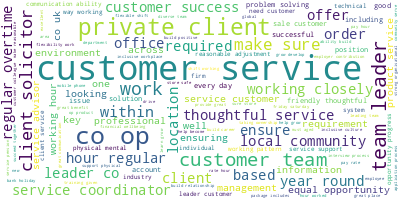

label: food


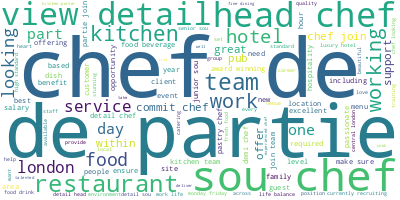

label: tech


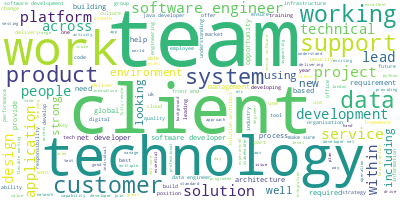

label: manufacturing


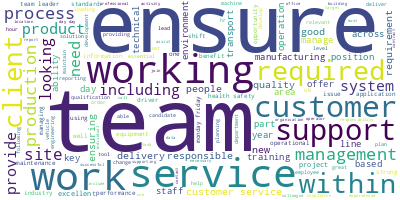

label: hr


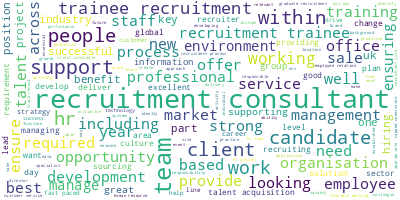

label: accounting


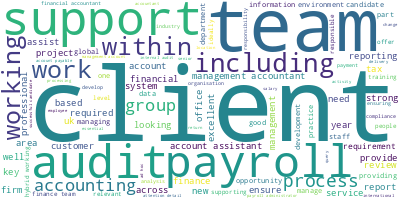

label: social_care


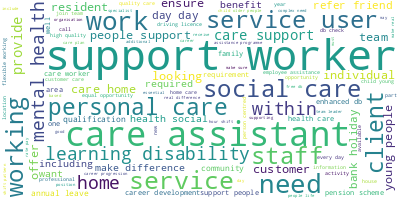

label: healthcare


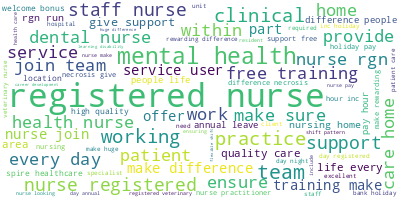

label: teaching


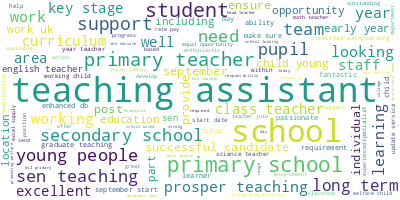

label: transportation


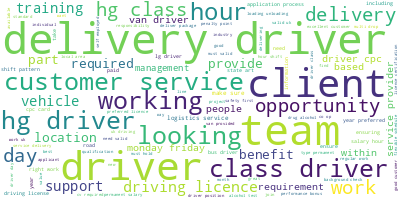

In [43]:
# Let's get the wordcloud for each label
for l in df["label"].unique():
    print("label: " + label_dict[l])
    display(build_wordcloud(df.loc[df["label"] == l]["doc"]))


 - We can see that each group has its own particular words (great!)
 - We can also see that are some common words between groups, such as "work", "team", "client" and so on.

 With more time, it could be a good idea to try and remove such common words and see if the performance of the models improve.

In [30]:
# Let's plot the distribution of classes in our dataset
df_plot = (
    df.groupby("label_explanation")["title"]
    .count()
    .reset_index()
    .rename(columns={"title": "n_occurrences"})
)
df_plot["n_occurrences"] = df_plot["n_occurrences"].astype("float")
fig = px.pie(
    data_frame=df_plot,
    values="n_occurrences",
    names="label_explanation",
    title="Distribution of classes in the dataset",
)
fig.show()
# We can see that the dataset in not completely balanced, however the situation is not dramatic. We will need to be careful to the transportation class in particular!


In [31]:
# Add some metrics
for col in ["doc", "title", "description"]:
    df[col + "_str_len"] = df[col].apply(lambda x: len(x))
    df[col + "_n_words"] = df[col].apply(lambda x: len(x.split(" ")))
    df[col + "_unique_words"] = df[col].apply(lambda x: len(set(x.split(" "))))


In [32]:
# Let's check the distribution of the char numbers per label. Tech and healtcare definetely have some really long ads!
fig = px.box(df, x="label_explanation", y="doc_str_len")
fig.show()


In [33]:
# Let's give a quick look at the distribution of the number of words. It is interesting to see the the food class has a very narrow square, with an impressive tail on the top of outliers.
fig = px.box(df, x="label_explanation", y="doc_n_words")
fig.show()


In [35]:
# There is nothing particular to note between the number of words and the number of unique words. Words repetition is not a peculiarity of some specific labels.
fig = px.box(df, x="label_explanation", y="doc_unique_words")
fig.show()


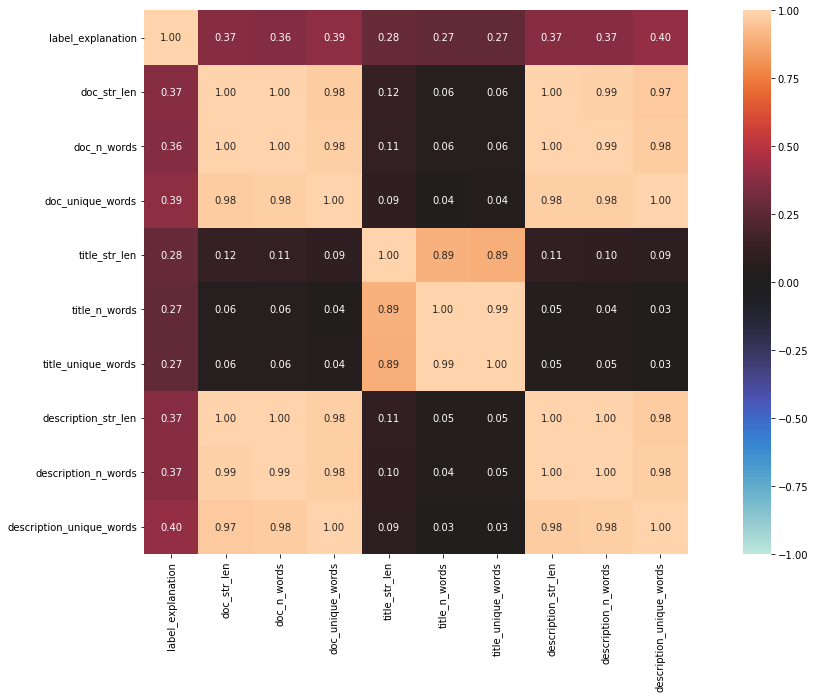

In [39]:
# One final common overview of our metrics. We can see that the description length and number of words is a bit related to the class, but the relation is still quite weak.
# Such relation is even weaker for the title.
from dython import nominal

df_plot = df.drop(columns=["label", "title", "description", "doc"], axis=1)
fig = nominal.associations(df_plot, figsize=(20, 10))


In [ ]:
df.drop(
    columns=[
        "doc_str_len",
        "doc_n_words",
        "doc_unique_words",
        "title_str_len",
        "title_n_words",
        "title_unique_words",
        "description_str_len",
        "description_n_words",
        "description_unique_words",
    ],
    axis=1,
    inplace=True,
)


### Checkpoint

In [45]:
# os.makedirs("Dataframes", exist_ok=True)
# df.to_csv("Dataframes/df_final.csv", index=False)


In [10]:
# df = pd.read_csv("Dataframes/df_final.csv")

## Building a classifier
We will now try different approaches to build a classifier. Before going on, I would like to spend some words about our problems. In job ads, what really matters is the fact that a word is present or not (and its count is important too). Therefore, we can use two different approaches: bag of words and tf-idf, while considering only the unigrams.

In [5]:
from sklearn.model_selection import GridSearchCV  # for the best params
from sklearn.metrics import confusion_matrix, accuracy_score  # for scores
from sklearn.model_selection import StratifiedKFold  # for kfold

X_doc = df["doc"]  # our feature
y = df["label"]  # target


In [6]:
# I will crate a custom kfold function because I'm interested in both the accuracy and the confusion matrix of the models.
# Why stratified k-fold? As we saw earlier, the dataset is not completely balanced.
# Using the stratified k-fold we should be able overcome this problem, at least in part.


def perform_stratifield_kfold(model, X, y):
    """Custom function for stratifield k-fold

    Args:
        model: the ML model
        X: feature dataset
        y: target variable

    Returns:
        list of accuracy scores per fold, list of confusion matrices per fold
    """
    conf_matrix_list = []
    accuracy_list = []
    kf = StratifiedKFold(shuffle=True, random_state=RANDOM_SEED, n_splits=5)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]  # get X of fold
        y_train, y_test = y[train_index], y[test_index]  # get y of fold
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_list.append(conf_matrix)
        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(accuracy)
    return accuracy_list, conf_matrix_list


def get_avg_conf_matrix(cms):
    """Function to build a single confusion matrix, as average of the input ones

    Args:
        cms list of confusion matrices
    Returns:
        avg confusion matrix of the folds
    """
    sum = cms[1]
    for i in range(1, len(cms)):
        sum = sum + cms[i]
    return sum / len(cms)


### Bag of words
When we deal with classification for this kind of problem, the most common approach is the "bag of words". We will create a sparse, high dimensional matrix with columns for each word and the single cells will be the count of the words for the current row.

In [7]:
# Let's build the bag of words from our doc
from sklearn.feature_extraction.text import CountVectorizer

matrix = CountVectorizer()
X = matrix.fit_transform(X_doc).toarray()


#### Naive Bayes (multinomial)

In [8]:
# Naive Bayes
# This is a simple model, however it works pretty well in document classification tasks
from sklearn.naive_bayes import MultinomialNB


def get_best_bayes(X, y):
    # Grid-search params
    params = {
        "alpha": [0.01, 0.1, 0.5, 1.0, 10.0],
    }
    print(" ---- Grid search ----")
    # Care: multi-process grid search
    bayes_grid = GridSearchCV(
        MultinomialNB(), param_grid=params, n_jobs=-1, cv=2, verbose=5
    )
    bayes_grid.fit(X, y)
    print("Best Parameters : ", bayes_grid.best_params_)
    return bayes_grid.best_estimator_


In [9]:
model = get_best_bayes(X, y)


 ---- Grid search ----
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END ........................alpha=0.01;, score=0.899 total time=  10.1s
[CV 1/2] END ........................alpha=10.0;, score=0.761 total time=  10.0s
[CV 2/2] END ........................alpha=10.0;, score=0.748 total time=  10.5s
[CV 1/2] END .........................alpha=0.5;, score=0.905 total time=  10.7s
[CV 1/2] END .........................alpha=0.1;, score=0.903 total time=  10.5s
[CV 1/2] END .........................alpha=1.0;, score=0.901 total time=  10.8s
[CV 2/2] END .........................alpha=0.1;, score=0.903 total time=  12.0s
[CV 2/2] END .........................alpha=1.0;, score=0.897 total time=  12.0s
[CV 2/2] END .........................alpha=0.5;, score=0.902 total time=  12.2s
[CV 2/2] END ........................alpha=0.01;, score=0.891 total time=  12.2s
Best Parameters :  {'alpha': 0.5}


In [11]:
print(" ---- Using the best bayes estimator ----")
accuracy_list, cms = perform_stratifield_kfold(model, X, y)


 ---- Using the best bayes estimator ----


The accuracy is: 0.91, with a standard deviation of 0.0


<AxesSubplot:>

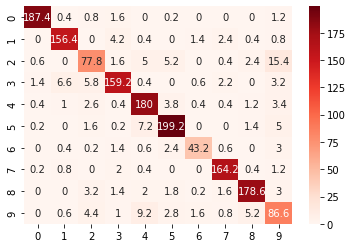

In [12]:
print(
    "The accuracy is: {0}, with a standard deviation of {1}".format(
        round(np.mean(np.array(accuracy_list)), 2), round(np.std(accuracy_list), 2)
    )
)
sns.heatmap(get_avg_conf_matrix(cms), annot=True, fmt="g", cmap="Reds")


We have a high accuracy and an incredibly fast execution time. We can sometimes see a bit of confusion with classes 2, 4 and 9 (customer service, hr and manufacturing).

#### Random forest

In [14]:
# Random forest
# This is an ensemble learning model. It is expected to work pretty well with unbalanced datasets, but it could have some problems with high-dimensional sparse features.
# I am really interested in seeing the tradeoff of pros and cons of this model for this particular task

from sklearn.ensemble import RandomForestClassifier


def get_best_forest(X, y):
    params = {
        "criterion": ["gini", "entropy"],
        "n_estimators": [10, 100, 200],
        "random_state": [RANDOM_SEED],
    }

    print(" ---- Grid search ----")
    # Care: multi-process grid search
    forest_grid = GridSearchCV(
        RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=2, verbose=5
    )
    forest_grid.fit(X, y)
    print("Best Parameters : ", forest_grid.best_params_)
    return forest_grid.best_estimator_


In [15]:
model = get_best_forest(X, y)


 ---- Grid search ----
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END criterion=gini, n_estimators=10, random_state=42;, score=0.794 total time=  11.5s
[CV 2/2] END criterion=entropy, n_estimators=10, random_state=42;, score=0.789 total time=  11.6s
[CV 1/2] END criterion=entropy, n_estimators=10, random_state=42;, score=0.754 total time=  12.3s
[CV 2/2] END criterion=gini, n_estimators=10, random_state=42;, score=0.811 total time=  12.9s
[CV 2/2] END criterion=entropy, n_estimators=100, random_state=42;, score=0.863 total time=  40.6s
[CV 1/2] END criterion=entropy, n_estimators=100, random_state=42;, score=0.847 total time=  42.4s
[CV 1/2] END criterion=gini, n_estimators=100, random_state=42;, score=0.875 total time=  43.7s
[CV 2/2] END criterion=gini, n_estimators=100, random_state=42;, score=0.883 total time=  44.7s
[CV 1/2] END criterion=gini, n_estimators=200, random_state=42;, score=0.884 total time=  59.9s
[CV 1/2] END criterion=entropy, n_estimators=

In [18]:
print(" ---- Using the best forest estimator ----")
accuracy_list, cms = perform_stratifield_kfold(model, X, y)


 ---- Using the best forest estimator ----


The accuracy is: 0.9, with a standard deviation of 0.01


<AxesSubplot:>

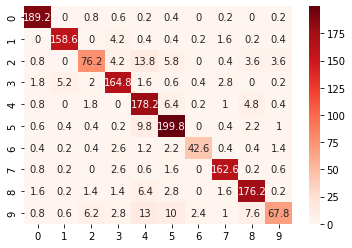

In [19]:
print(
    "The accuracy is: {0}, with a standard deviation of {1}".format(
        round(np.mean(np.array(accuracy_list)), 2), round(np.std(accuracy_list), 2)
    )
)
sns.heatmap(get_avg_conf_matrix(cms), annot=True, fmt="g", cmap="Reds")


Still a high accuracy, but with an increase in computation time. This time the models seems to face some issues between classes 2-4 and 9-4, 9-5. (2: customer service, 4: hr, 5: tech, 9: manufacturing)

#### Logistic Regression

In [20]:
# Logistic regression
# This is one of the most common models for classification tasks.
# While pretty easy, it often provids decent results with a not too heavy computational weigth.
# I expect a good result with lasso (l2), since it should work well with high-dimensional sparse data.
# We also have the option to specify a parameter for better balancing the predictions according to class frequencies.
from sklearn.linear_model import LogisticRegression


def get_log_reg_model(X, y):
    # This time, I do not want to perform the grid search, since I want to test some specific parameters
    model = LogisticRegression(
        penalty="l2", random_state=RANDOM_SEED, solver="lbfgs", class_weight="balanced"
    )
    return model


In [21]:
model = get_log_reg_model(X, y)


In [23]:
print(" ---- Using the log_reg estimator ----")
accuracy_list, cms = perform_stratifield_kfold(model, X, y)


 ---- Using the log_reg estimator ----


The accuracy is: 0.93, with a standard deviation of 0.01


<AxesSubplot:>

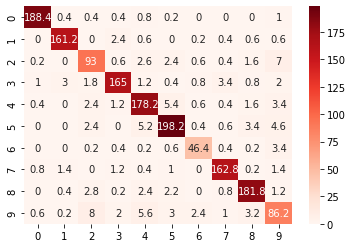

In [24]:
print(
    "The accuracy is: {0}, with a standard deviation of {1}".format(
        round(np.mean(np.array(accuracy_list)), 2), round(np.std(accuracy_list), 2)
    )
)
sns.heatmap(get_avg_conf_matrix(cms), annot=True, fmt="g", cmap="Reds")


Best accuracy so far and a decent computation time. Also, the errors seem to be distributed among the classes with no special issues to highlight.

### TF_IDF

TF-IDF is short for "term frequency–inverse document frequency", and it focuses on finding the important classification words for each document. Term frequency of a word in a document increases its score, and document frequency (the number of documents where the word shows up) decreases the score.

In [25]:
# Let's build the TF_IDFs from our doc
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["doc"]).toarray()


#### Naive Bayes (multinomial)

In [26]:
model = get_best_bayes(X, y)


 ---- Grid search ----
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 2/2] END .........................alpha=0.1;, score=0.882 total time=   5.1s
[CV 1/2] END ........................alpha=0.01;, score=0.896 total time=   5.1s
[CV 1/2] END ........................alpha=10.0;, score=0.775 total time=   5.1s
[CV 2/2] END .........................alpha=0.5;, score=0.836 total time=   5.3s
[CV 1/2] END .........................alpha=0.5;, score=0.831 total time=   4.9s
[CV 2/2] END .........................alpha=1.0;, score=0.809 total time=   4.9s
[CV 1/2] END .........................alpha=0.1;, score=0.885 total time=   5.7s
[CV 2/2] END ........................alpha=0.01;, score=0.888 total time=   5.8s
[CV 1/2] END .........................alpha=1.0;, score=0.805 total time=   5.7s
[CV 2/2] END ........................alpha=10.0;, score=0.771 total time=   5.7s
Best Parameters :  {'alpha': 0.01}


In [29]:
print(" ---- Using the best bayes estimator ----")
accuracy_list, cms = perform_stratifield_kfold(model, X, y)


 ---- Using the best bayes estimator ----


The accuracy is: 0.9, with a standard deviation of 0.0


<AxesSubplot:>

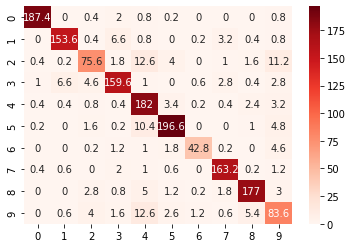

In [30]:
print(
    "The accuracy is: {0}, with a standard deviation of {1}".format(
        round(np.mean(np.array(accuracy_list)), 2), round(np.std(accuracy_list), 2)
    )
)
sns.heatmap(get_avg_conf_matrix(cms), annot=True, fmt="g", cmap="Reds")


Interestingly, the accuracy is the same with bag of words or TF-IDF. Also, the classes with some issues are still 2, 4 and 9.

#### Random forest

In [31]:
model = get_best_forest(X, y)


 ---- Grid search ----
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END criterion=gini, n_estimators=10, random_state=42;, score=0.809 total time=  10.0s
[CV 2/2] END criterion=gini, n_estimators=10, random_state=42;, score=0.824 total time=  11.5s
[CV 2/2] END criterion=entropy, n_estimators=10, random_state=42;, score=0.780 total time=  12.0s
[CV 1/2] END criterion=entropy, n_estimators=10, random_state=42;, score=0.759 total time=  12.8s
[CV 1/2] END criterion=entropy, n_estimators=100, random_state=42;, score=0.858 total time=  38.6s
[CV 2/2] END criterion=entropy, n_estimators=100, random_state=42;, score=0.871 total time=  40.7s
[CV 2/2] END criterion=gini, n_estimators=100, random_state=42;, score=0.894 total time=  41.1s
[CV 1/2] END criterion=gini, n_estimators=100, random_state=42;, score=0.889 total time=  43.0s
[CV 1/2] END criterion=entropy, n_estimators=200, random_state=42;, score=0.863 total time=  57.9s
[CV 2/2] END criterion=entropy, n_estimato

In [34]:
print(" ---- Using the best forest estimator ----")
accuracy_list, cms = perform_stratifield_kfold(model, X, y)


 ---- Using the best forest estimator ----


The accuracy is: 0.91, with a standard deviation of 0.01


<AxesSubplot:>

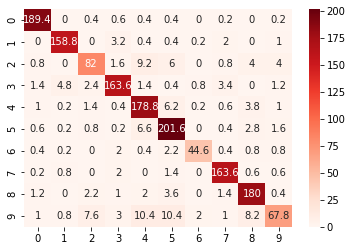

In [35]:
print(
    "The accuracy is: {0}, with a standard deviation of {1}".format(
        round(np.mean(np.array(accuracy_list)), 2), round(np.std(accuracy_list), 2)
    )
)
sns.heatmap(get_avg_conf_matrix(cms), annot=True, fmt="g", cmap="Reds")


As before, similar performance to its bag of words counterpart. This time, the misclassification issues seem to also include class 8 (accounting)

#### Logistic regression

In [36]:
model = get_log_reg_model(X, y)


In [39]:
print(" ---- Using the log_reg estimator ----")
accuracy_list, cms = perform_stratifield_kfold(model, X, y)


 ---- Using the log_reg estimator ----


The accuracy is: 0.93, with a standard deviation of 0.01


<AxesSubplot:>

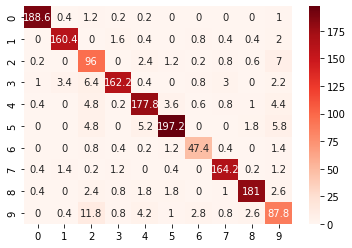

In [40]:
print(
    "The accuracy is: {0}, with a standard deviation of {1}".format(
        round(np.mean(np.array(accuracy_list)), 2), round(np.std(accuracy_list), 2)
    )
)
sns.heatmap(get_avg_conf_matrix(cms), annot=True, fmt="g", cmap="Reds")


Similar accuracy score, but this version has more specific misclassification errors.

### Bert

As last step for this project, I chose to try implementing a deep learnign model using Google's pre-trained BERT.
<br>
To do that, I will use the transformers library from Hugging Face and the Tensorflow+Keras framework. It is the first time that I work with BERT, but I am sure that the result will not be disappointing.
<br>
BERT is a transformer which is pre-trained by Google on the English Wikipedia and on the Toronto Book Corpus.

In [5]:
# import libraries
import transformers
import tensorflow as tf

tf.get_logger().setLevel("ERROR")


In [11]:
# preparing the dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

n_labels = df["label"].nunique()

y = tf.keras.utils.to_categorical(df["label"].values, num_classes=n_labels)

X_train, X_val, y_train, y_val = train_test_split(
    df["doc"], y, test_size=0.25, random_state=RANDOM_SEED
)


In [12]:
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Bert tokenizer
bert = TFBertModel.from_pretrained("bert-base-uncased")  # Bert Embedder


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
# Tokenize the input
X_token_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=50,  # this is a decent value that also allows a decent computation time.
    # lookint at the titles analysis we are sure to take always all the titles and also the beginning of the description.
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True,
)
X_token_val = tokenizer(
    text=X_val.tolist(),
    add_special_tokens=True,
    max_length=50,
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True,
)


In [14]:
# building the network
from tensorflow.keras.layers import Input, Dense

max_len = 50
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert.bert(input_ids, attention_mask=input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D(name="MaxPooling_Layer")(embeddings)
out = Dense(128, activation="relu", name="Relu_layer")(out)
out = tf.keras.layers.Dropout(0.1, name="Dropout_layer")(out)
y = Dense(10, activation="softmax", name="Classification_layer")(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True


In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# I used the suggested values for Adam from HuggingFace
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
# Set loss and metrics
loss = CategoricalCrossentropy()
metric = (CategoricalAccuracy("balanced_accuracy"),)
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metric)


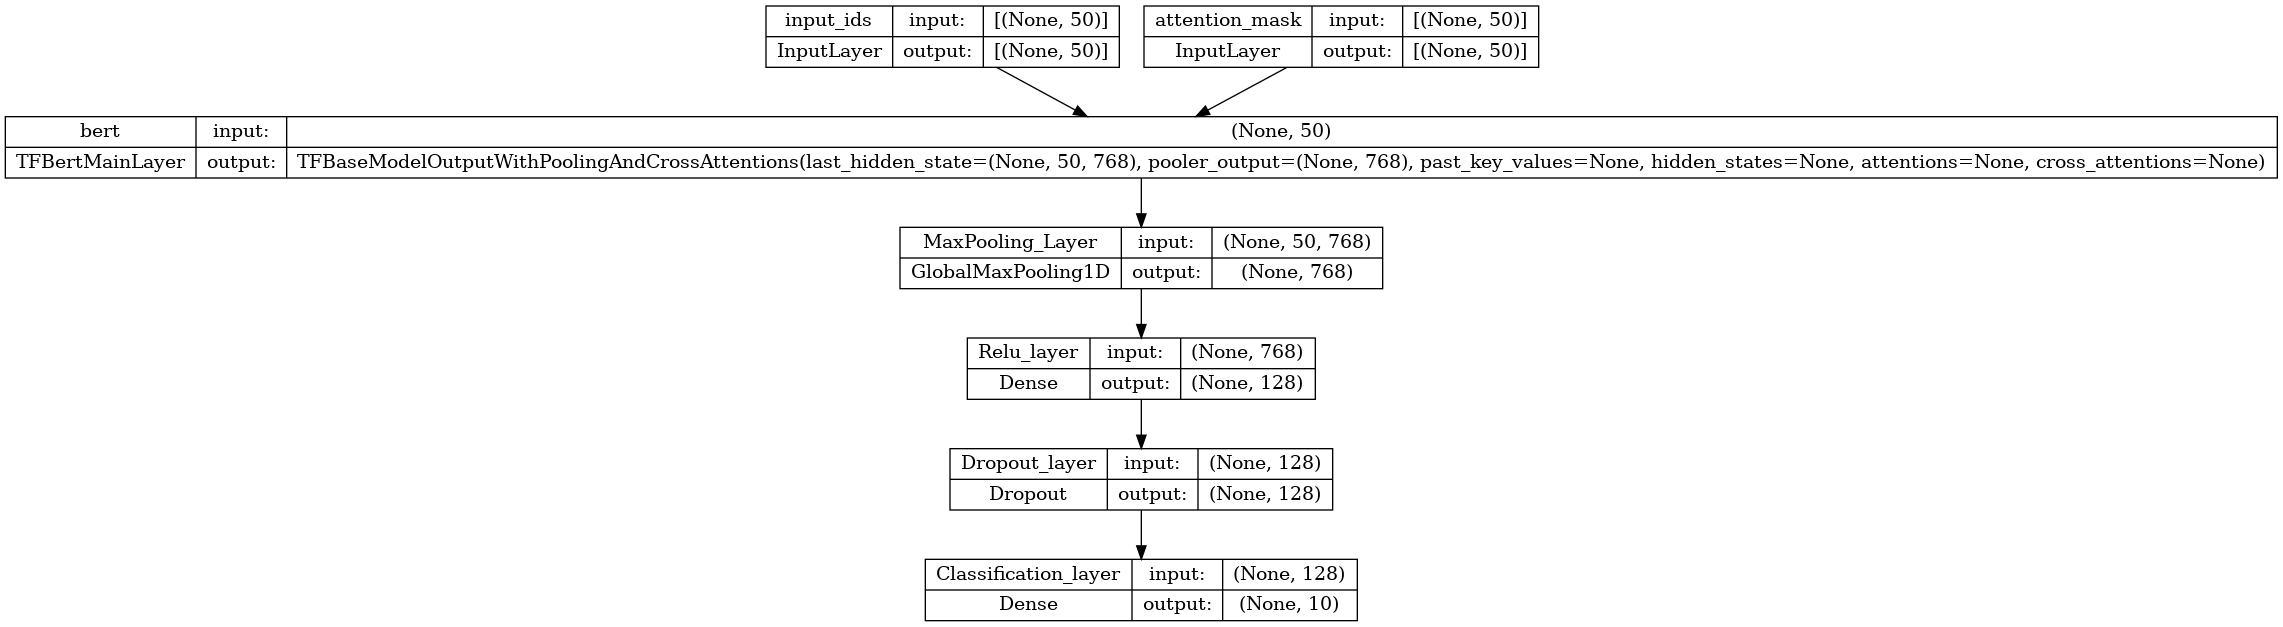

In [16]:
# Let's give a look at our model's structure
tf.keras.utils.plot_model(
    model, to_file="prova.png", show_shapes=True, show_layer_names=True
)


In [17]:
# Training the model
train_history = model.fit(
    x={
        "input_ids": X_token_train["input_ids"],
        "attention_mask": X_token_train["attention_mask"],
    },
    y=y_train,
    validation_data=(
        {
            "input_ids": X_token_val["input_ids"],
            "attention_mask": X_token_val["attention_mask"],
        },
        y_val,
    ),
    epochs=3,  # From previous investigation, a higher number of epochs does not increase accuracy or reduce loss by much
    batch_size=32,  # Unfortunately, my pc was not able to handle larger batch sizes
)


Epoch 1/3


2022-08-04 15:43:45.164028: E tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute epsilon which is not in the op definition: Op<name=_MklFusedBatchMatMulV2; signature=x:T, y:T, args:num_args*T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_FLOAT]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false; attr=num_args:int,min=0; attr=fused_ops:list(string),default=[]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node model/bert/encoder/layer_._0/attention/self/ArithmeticOptimizer/AddOpsRewrite_add_1}}


185/185 [==============================] - 647s 3s/step - loss: 0.5063 - balanced_accuracy: 0.8517 - val_loss: 0.1971 - val_balanced_accuracy: 0.9458
Epoch 2/3
185/185 [==============================] - 661s 4s/step - loss: 0.1575 - balanced_accuracy: 0.9552 - val_loss: 0.1643 - val_balanced_accuracy: 0.9549
Epoch 3/3
185/185 [==============================] - 758s 4s/step - loss: 0.1021 - balanced_accuracy: 0.9708 - val_loss: 0.1696 - val_balanced_accuracy: 0.9529


In [26]:
# Let's try some predictions

# Some custom predictions, one per class
X_to_predict = [
    "payroll expert wanted",
    "customer user team leader",
    "maths teaching secondary school",
    "chef for new restaurant",
    "staffing recruiter bilingual",
    "registered expert nurse",
    "remote java developer",
    "cnc machine operator",
    "support worker for elderly",
    "delivery driver for night shift",
]

# label explanation
label_dict = {
    0: "food",
    1: "healthcare",
    2: "customer_service",
    3: "social_care",
    4: "hr",
    5: "tech",
    6: "transportation",
    7: "teaching",
    8: "accounting",
    9: "manufacturing",
}

# tokenize input
X_token_to_predict = tokenizer(
    text=X_to_predict,
    add_special_tokens=True,
    max_length=50,
    truncation=True,
    padding="max_length",
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True,
)

# predict
predictions = model.predict(
    {
        "input_ids": X_token_to_predict["input_ids"],
        "attention_mask": X_token_to_predict["attention_mask"],
    }
)

# print results
for x, y in zip(X_to_predict, predictions):
    print(
        "For job '{0}', the model predicted class {1} ({2})".format(
            x, np.argmax(y), label_dict[np.argmax(y)]
        )
    )


1/1 [==============================] - 0s 237ms/step
For job 'payroll expert wanted', the model predicted class 8 (accounting)
For job 'customer user team leader', the model predicted class 2 (customer_service)
For job 'maths teaching secondary school', the model predicted class 7 (teaching)
For job 'chef for new restaurant', the model predicted class 0 (food)
For job 'staffing recruiter bilingual', the model predicted class 4 (hr)
For job 'registered expert nurse', the model predicted class 1 (healthcare)
For job 'remote java developer', the model predicted class 5 (tech)
For job 'cnc machine operator', the model predicted class 9 (manufacturing)
For job 'support worker for elderly', the model predicted class 3 (social_care)
For job 'delivery driver for night shift', the model predicted class 6 (transportation)


## Final remarks

Overall, I am satisfied with the results that were obtained in the notebook. The exploration and preprocessing phases were though, but necessary in order to be able to label the data correctly and to develop a classifier. I particularly enjoyed building the LDA model and analyzing the similarities and the differences between the clusters. Regarding the classifiers, I was impressed by both the accuracy and the low execution time of the multinomial Bayesian classifier. This project also gave me the chance to finally perform some experiments BERT and the results are incredibly promising: with more experience about fine-tuning the network and maybe with some more time spent on preprocessing and configuration of the model, I am sure that things could be improved even further.